In [1]:
import pandas as pd
import numpy as np
import os
import random

import torch
import torch.nn as nn
import os
import itertools
import json
import traceback

from datetime import datetime
from tqdm import tqdm
from pathlib import Path
from dotenv import load_dotenv
from torch.utils.data import DataLoader, TensorDataset

from trajectory_predictor import TrajectoryPredictor, trajectory_loss, DEVICE

BASE = "../../data/aisdk"

# 0 - Fetch the data

In [2]:
train_traj = np.load(os.path.join(BASE, "windows/train_trajectories.npz"))
val_traj = np.load(os.path.join(BASE, "windows/val_trajectories.npz"))
# test_traj = np.load(os.path.join(BASE, "windows/test_trajectories.npz"))

X_train, X_val = train_traj["past"], val_traj["past"]
y_train, y_val = train_traj["future"], val_traj["future"]
c_train, c_val = train_traj["cluster"], val_traj["cluster"]

In [3]:
# %% Create data loaders
def make_loaders(batch_size, cid, min_samples=10):
    """
    Build train/val dataloaders for a single cluster `cid`.
    Returns (train_loader, val_loader). Raises if not enough data for a given cluster.
    """

    # Boolean masks for this cluster
    train_mask = (c_train == cid)
    val_mask   = (c_val == cid)

    # Subset numpy arrays
    X_tr = X_train[train_mask]
    y_tr = y_train[train_mask]
    X_v  = X_val[val_mask]
    y_v  = y_val[val_mask]

    n_tr, n_v = X_tr.shape[0], X_v.shape[0]
    print(f"\n[Cluster {cid}] Num train windows: {n_tr}, Num val windows: {n_v}")
    
    if n_tr < min_samples or n_v < min_samples:
        raise RuntimeError(
            f"Not enough samples for cluster {cid}: "
            f"{n_tr} train, {n_v} val (min {min_samples})."
        )

    # %% Convert to PyTorch tensors
    X_train_t = torch.tensor(X_tr, dtype=torch.float32)
    X_val_t   = torch.tensor(X_v,   dtype=torch.float32)

    y_train_t = torch.tensor(y_tr, dtype=torch.float32)
    y_val_t   = torch.tensor(y_v,   dtype=torch.float32)

    # Create data loaders
    print(f"[Cluster {cid}] Tensor shapes:")
    print(f"  X_train_t: {X_train_t.shape}")
    print(f"  X_val_t:   {X_val_t.shape}")
    print(f"  y_train_t: {y_train_t.shape}")
    print(f"  y_val_t:   {y_val_t.shape}")

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader


# 1 - Define training functions 
## 1.1 - One run

In [4]:
def _train_one_run(cfg, train_loader, val_loader, cid):
    """
    Train a TrajectoryPredictor for one hyperparameter configuration.

    Returns:
      model,
      train_mses, val_mses,
      train_rmses, val_rmses,
      best_val_mse, best_epoch
    """

    device = cfg["device"]

    model = TrajectoryPredictor(
        input_dim=cfg["input_dim"],
        hidden_dim=cfg["hidden_dim"],
        output_dim=cfg["output_dim"],
        num_layers_encoder=cfg["num_layers_encoder"],
        num_layers_decoder=cfg["num_layers_decoder"],
        attn_dim=cfg["attn_dim"]
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

    best_val_mse = float("inf")
    best_epoch = -1

    train_mses = []
    val_mses   = []
    train_rmses = []
    val_rmses   = []

    # ------ Training loop ------ 
    for epoch in range(1, cfg["epochs"] + 1):

        model.train()
        train_total = 0.0
        train_samples = 0

        for xb, yb in tqdm(train_loader, desc=f"Cluster {cid} Epoch {epoch}/{cfg['epochs']}"):
            xb = xb.to(device)
            yb = yb.to(device)


            opt.zero_grad()
            yb_pred = model(xb, target_length=yb.size(1), targets=yb, teacher_forcing_ratio=cfg["teacher_forcing"])
            
            loss = trajectory_loss(yb_pred, yb)
            loss.backward()
            
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=cfg["max_norm"])
            opt.step()
            train_total += loss.item() * xb.size(0)
            train_samples += xb.size(0)


        train_mse = train_total / max(train_samples, 1)
        train_rmse = float(np.sqrt(train_mse))


        # --- VALIDATION ---
        model.eval()
        val_total = 0.0
        val_samples = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)

                yb_pred = model(
                    xb,
                    target_length=yb.size(1),
                    targets=None,
                    teacher_forcing_ratio=0.0
                )

                loss = trajectory_loss(yb_pred, yb)
                

                val_total += loss.item() * xb.size(0)
                val_samples += xb.size(0)

        val_mse = val_total / max(val_samples, 1)
        val_rmse = float(np.sqrt(val_mse))

        train_mses.append(train_mse)
        val_mses.append(val_mse)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)

        print(
            f"[Cluster {cid}] Epoch {epoch}/{cfg['epochs']} "
            f"| Train MSE: {train_mse:.6f} (RMSE: {train_rmse:.6f}) "
            f"| Val MSE: {val_mse:.6f} (RMSE: {val_rmse:.6f})"
        )

        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_epoch = epoch
            print(
                f"  → New best Val MSE for cluster {cid}: {best_val_mse:.6f} "
                f"(RMSE: {val_rmse:.6f}, epoch {epoch})"
            )

    return model, train_mses, val_mses, train_rmses, val_rmses, best_val_mse, best_epoch,
    


## 1.2 - Function for hyperparameter tuning

In [5]:
# Define key metrics
input_dim = X_train.shape[-1]
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def hyperparameter_search_trajectory(
    device=device,
    input_dim=input_dim,
    output_dim=input_dim,
    cid=3,
    search_type='grid',
    save_dir='../../checkpoints/predictor',
):
    os.makedirs(save_dir, exist_ok=True)

    print("=" * 70)
    print(f"HYPERPARAMETER TUNING FOR TRAJECTORY PREDICTOR (Cluster {cid})")
    N_t = np.sum(c_train == cid)
    N_v = np.sum(c_val == cid)
    print(f"Number of training samples in cluster {cid}: {N_t}")
    print(f"Number of validation samples in cluster {cid}: {N_v}")
    print("=" * 70)

    # -------- 1) Define search space --------
    if search_type == 'grid':
        param_grid = {
            "hidden_dim": [32, 64],
            "num_layers_encoder": [1],
            "num_layers_decoder": [1],
            "attn_dim": [32],
            "batch_size": [128],

            "lr": [3e-4, 1e-3],
            "weight_decay": [0.0, 1e-4],
            "teacher_forcing": [0.7], #0.7 for stability unless predictions drift badly — then increase to 1.0.
            "max_norm": [1.0],
            "epochs": [20],
        }
        # 2 * 1 * 1 * 1 * 1 * 2 * 2 * 1 * 1 * 1 = 8 configs

    elif search_type == 'quick':
            param_grid = {
        "hidden_dim": [64, 128],
        "num_layers_encoder": [1],     
        "num_layers_decoder": [1],     
        "attn_dim": [64],              
        "batch_size": [128],          
        "lr": [3e-4, 1e-3],
        "weight_decay": [0.0, 1e-4],
        "teacher_forcing": [0.7],
        "max_norm": [1.0],
        "epochs": [15],
        }
        

    else:
        raise ValueError(f"Unknown search_type: {search_type}")

    keys = list(param_grid.keys())
    values = list(param_grid.values())
    combinations = list(itertools.product(*values))
    param_combinations = [dict(zip(keys, combo)) for combo in combinations]

    print(f"{search_type.capitalize()} Search: {len(param_combinations)} combinations")
    print(f"Estimated time: {len(param_combinations) * 5} minutes (VERY rough)")
    print("=" * 70)

    results = []
    best_score = float("inf")  # here: best_val_mse
    best_params = None

    start_time = datetime.now()

    # -------- 2) Main loop over configs --------
    for idx, params in enumerate(param_combinations):
        print("\n" + "=" * 70)
        print(f"Trial {idx + 1}/{len(param_combinations)}  (Cluster {cid})")
        elapsed_min = (datetime.now() - start_time).total_seconds() / 60
        print(f"Time elapsed: {elapsed_min:.1f} min")
        print("=" * 70)

        print("Testing configuration:")
        print(f"  hidden_dim        = {params['hidden_dim']}")
        print(f"  num_layers_enc    = {params['num_layers_encoder']}")
        print(f"  num_layers_dec    = {params['num_layers_decoder']}")
        print(f"  attn_dim          = {params['attn_dim']}")
        print(f"  batch_size        = {params['batch_size']}")
        print(f"  lr                = {params['lr']}")
        print(f"  weight_decay      = {params['weight_decay']}")
        print(f"  teacher_forcing   = {params['teacher_forcing']}")
        print(f"  max_norm          = {params['max_norm']}")
        print(f"  epochs            = {params['epochs']}")
        print()

        try:
            # ---- Build cfg for this run ----
            cfg = {
                "device": device,
                "input_dim": input_dim,
                "output_dim": output_dim,
                "hidden_dim": params["hidden_dim"],
                "num_layers_encoder": params["num_layers_encoder"],
                "num_layers_decoder": params["num_layers_decoder"],
                "attn_dim": params["attn_dim"],
                "batch_size": params["batch_size"],
                "lr": params["lr"],
                "weight_decay": params["weight_decay"],
                "teacher_forcing": params["teacher_forcing"],
                "max_norm": params["max_norm"],
                "epochs": params["epochs"],
            }

            # ---- Train once with this config ----
            train_loader, val_loader = make_loaders(cfg["batch_size"], cid)
            model, train_mses, val_mses, train_rmses, val_rmses, best_val_mse, best_epoch = _train_one_run(cfg, train_loader, val_loader, cid)

            score = float(best_val_mse)

            final_train_mse = float(train_mses[best_epoch - 1])
            final_train_rmse = float(train_rmses[best_epoch - 1])
            best_val_rmse = float(val_rmses[best_epoch - 1])
            overfit_ratio = best_val_mse / max(final_train_mse, 1e-8)


            result = {
                **params,
                "best_val_mse": best_val_mse,
                "best_val_rmse": best_val_rmse,
                "best_epoch": best_epoch,
                "final_train_mse": final_train_mse,
                "final_train_rmse": final_train_rmse,
                "overfit_ratio": overfit_ratio,
                "score": score,  # for sorting
                "trial": idx + 1,
            }

            results.append(result)

            print("Results:")
            print(f"  Best Val MSE : {best_val_mse:.6f} (RMSE: {best_val_rmse:.6f}, epoch {best_epoch})")
            print(f"  Train MSE @best: {final_train_mse:.6f} (RMSE: {final_train_rmse:.6f})")
            print(f"  Overfit ratio : {overfit_ratio:.3f}")
            print(f"  Score (Val MSE): {score:.6f}")

            if score < best_score:
                best_score = score
                best_params = params.copy()
                print("  ⭐ NEW BEST CONFIG FOUND!")
                
                torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))

            # Optionally clear cache if GPU:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        except Exception as e:
            print(f"  ❌ FAILED: {str(e)}")
            traceback.print_exc()
            result = {**params, "error": str(e), "trial": idx + 1}
            results.append(result)

    # -------- 3) Save & summarize --------
    if len(results) == 0:
        print("\n❌ No trials completed!")
        return None, None

    df = pd.DataFrame(results)

    if "score" in df.columns:
        df = df.sort_values("score", na_position="last")

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_path = os.path.join(save_dir, f"results_cluster{cid}_{timestamp}.csv")
    df.to_csv(csv_path, index=False)

    if best_params is None:
        print("\n❌ All trials failed! Check error messages above.")
        return df, None

    json_path = os.path.join(save_dir, f"best_params_cluster{cid}_{timestamp}.json")
    with open(json_path, "w") as f:
        json.dump(best_params, f, indent=2)

    total_time = (datetime.now() - start_time).total_seconds() / 60
    print("\n" + "=" * 70)
    print(f"HYPERPARAMETER SEARCH COMPLETE (Cluster {cid})")
    print("=" * 70)
    print(f"Total time: {total_time:.1f} minutes")
    successful = [r for r in results if "error" not in r]
    print(f"Successful trials: {len(successful)}/{len(results)}")

    print(f"\nBest parameters (score={best_score:.6f}):")
    for k, v in best_params.items():
        print(f"  {k}: {v}")

    print(f"\nResults saved to: {csv_path}")
    print(f"Best params saved to: {json_path}")

    # Top 5 successful configs
    successful_df = df[df["score"].notna()]
    
    top_cols = [
    "hidden_dim",
    "num_layers_encoder",
    "num_layers_decoder",
    "attn_dim",
    "lr",
    "teacher_forcing",
    "weight_decay",
    "best_val_mse",
    "best_val_rmse",
    "final_train_mse",
    "final_train_rmse",
    "overfit_ratio",
    "score",
    ]   
    print("\nTop 5 configurations:")
    print(successful_df[top_cols].head())

    return df, best_params


# 2 - Fetch the data

In [15]:
import itertools
device = "mps" if torch.backends.mps.is_available() else "cpu"

input_dim = 5          # e.g. [UTM_x, UTM_y, SOG, v_east, v_north]
output_dim = 5         # same features for future sequence

# Choose which cluster to train
cid = -1

# Train noise for example
df_traj, best_params_traj = hyperparameter_search_trajectory(
    device=device,
    input_dim=input_dim,
    output_dim=output_dim,
    cid=cid,
    search_type="quick",   # or "grid"
)

HYPERPARAMETER TUNING FOR TRAJECTORY PREDICTOR (Cluster -1)
Number of training samples in cluster -1: 143431
Number of validation samples in cluster -1: 25641
Quick Search: 8 combinations
Estimated time: 40 minutes (VERY rough)

Trial 1/8  (Cluster -1)
Time elapsed: 0.0 min
Testing configuration:
  hidden_dim        = 64
  num_layers_enc    = 1
  num_layers_dec    = 1
  attn_dim          = 64
  batch_size        = 128
  lr                = 0.0003
  weight_decay      = 0.0
  teacher_forcing   = 0.7
  max_norm          = 1.0
  epochs            = 15


[Cluster -1] Num train windows: 143431, Num val windows: 25641
[Cluster -1] Tensor shapes:
  X_train_t: torch.Size([143431, 30, 5])
  X_val_t:   torch.Size([25641, 30, 5])
  y_train_t: torch.Size([143431, 30, 5])
  y_val_t:   torch.Size([25641, 30, 5])


Cluster -1 Epoch 1/15: 100%|██████████| 1121/1121 [01:00<00:00, 18.67it/s]


[Cluster -1] Epoch 1/15 | Train MSE: 0.045181 (RMSE: 0.212558) | Val MSE: 0.056801 (RMSE: 0.238330)
  → New best Val MSE for cluster -1: 0.056801 (RMSE: 0.238330, epoch 1)


Cluster -1 Epoch 2/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.37it/s]


[Cluster -1] Epoch 2/15 | Train MSE: 0.002845 (RMSE: 0.053340) | Val MSE: 0.059920 (RMSE: 0.244786)


Cluster -1 Epoch 3/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.26it/s]


[Cluster -1] Epoch 3/15 | Train MSE: 0.002241 (RMSE: 0.047339) | Val MSE: 0.045914 (RMSE: 0.214276)
  → New best Val MSE for cluster -1: 0.045914 (RMSE: 0.214276, epoch 3)


Cluster -1 Epoch 4/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.34it/s]


[Cluster -1] Epoch 4/15 | Train MSE: 0.002067 (RMSE: 0.045468) | Val MSE: 0.043778 (RMSE: 0.209232)
  → New best Val MSE for cluster -1: 0.043778 (RMSE: 0.209232, epoch 4)


Cluster -1 Epoch 5/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.17it/s]


[Cluster -1] Epoch 5/15 | Train MSE: 0.001914 (RMSE: 0.043745) | Val MSE: 0.044829 (RMSE: 0.211729)


Cluster -1 Epoch 6/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.22it/s]


[Cluster -1] Epoch 6/15 | Train MSE: 0.001854 (RMSE: 0.043058) | Val MSE: 0.043351 (RMSE: 0.208208)
  → New best Val MSE for cluster -1: 0.043351 (RMSE: 0.208208, epoch 6)


Cluster -1 Epoch 7/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.11it/s]


[Cluster -1] Epoch 7/15 | Train MSE: 0.001818 (RMSE: 0.042640) | Val MSE: 0.059620 (RMSE: 0.244172)


Cluster -1 Epoch 8/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.15it/s]


[Cluster -1] Epoch 8/15 | Train MSE: 0.001836 (RMSE: 0.042854) | Val MSE: 0.047008 (RMSE: 0.216813)


Cluster -1 Epoch 9/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.19it/s]


[Cluster -1] Epoch 9/15 | Train MSE: 0.001794 (RMSE: 0.042360) | Val MSE: 0.056347 (RMSE: 0.237375)


Cluster -1 Epoch 10/15: 100%|██████████| 1121/1121 [01:02<00:00, 17.96it/s]


[Cluster -1] Epoch 10/15 | Train MSE: 0.001774 (RMSE: 0.042120) | Val MSE: 0.045842 (RMSE: 0.214109)


Cluster -1 Epoch 11/15: 100%|██████████| 1121/1121 [01:02<00:00, 17.93it/s]


[Cluster -1] Epoch 11/15 | Train MSE: 0.001710 (RMSE: 0.041350) | Val MSE: 0.052896 (RMSE: 0.229992)


Cluster -1 Epoch 12/15: 100%|██████████| 1121/1121 [01:02<00:00, 18.07it/s]


[Cluster -1] Epoch 12/15 | Train MSE: 0.001738 (RMSE: 0.041695) | Val MSE: 0.060631 (RMSE: 0.246233)


Cluster -1 Epoch 13/15: 100%|██████████| 1121/1121 [01:02<00:00, 17.88it/s]


[Cluster -1] Epoch 13/15 | Train MSE: 0.001697 (RMSE: 0.041195) | Val MSE: 0.049198 (RMSE: 0.221807)


Cluster -1 Epoch 14/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.18it/s]


[Cluster -1] Epoch 14/15 | Train MSE: 0.001678 (RMSE: 0.040963) | Val MSE: 0.053809 (RMSE: 0.231968)


Cluster -1 Epoch 15/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.20it/s]


[Cluster -1] Epoch 15/15 | Train MSE: 0.001652 (RMSE: 0.040646) | Val MSE: 0.053074 (RMSE: 0.230377)
Results:
  Best Val MSE : 0.043351 (RMSE: 0.208208, epoch 6)
  Train MSE @best: 0.001854 (RMSE: 0.043058)
  Overfit ratio : 23.382
  Score (Val MSE): 0.043351
  ⭐ NEW BEST CONFIG FOUND!

Trial 2/8  (Cluster -1)
Time elapsed: 16.3 min
Testing configuration:
  hidden_dim        = 64
  num_layers_enc    = 1
  num_layers_dec    = 1
  attn_dim          = 64
  batch_size        = 128
  lr                = 0.0003
  weight_decay      = 0.0001
  teacher_forcing   = 0.7
  max_norm          = 1.0
  epochs            = 15


[Cluster -1] Num train windows: 143431, Num val windows: 25641
[Cluster -1] Tensor shapes:
  X_train_t: torch.Size([143431, 30, 5])
  X_val_t:   torch.Size([25641, 30, 5])
  y_train_t: torch.Size([143431, 30, 5])
  y_val_t:   torch.Size([25641, 30, 5])


Cluster -1 Epoch 1/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.13it/s]


[Cluster -1] Epoch 1/15 | Train MSE: 0.050201 (RMSE: 0.224056) | Val MSE: 0.051665 (RMSE: 0.227300)
  → New best Val MSE for cluster -1: 0.051665 (RMSE: 0.227300, epoch 1)


Cluster -1 Epoch 2/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.19it/s]


[Cluster -1] Epoch 2/15 | Train MSE: 0.003434 (RMSE: 0.058602) | Val MSE: 0.048846 (RMSE: 0.221011)
  → New best Val MSE for cluster -1: 0.048846 (RMSE: 0.221011, epoch 2)


Cluster -1 Epoch 3/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.10it/s]


[Cluster -1] Epoch 3/15 | Train MSE: 0.002613 (RMSE: 0.051113) | Val MSE: 0.050922 (RMSE: 0.225660)


Cluster -1 Epoch 4/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.10it/s]


[Cluster -1] Epoch 4/15 | Train MSE: 0.002291 (RMSE: 0.047861) | Val MSE: 0.046824 (RMSE: 0.216389)
  → New best Val MSE for cluster -1: 0.046824 (RMSE: 0.216389, epoch 4)


Cluster -1 Epoch 5/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.10it/s]


[Cluster -1] Epoch 5/15 | Train MSE: 0.002151 (RMSE: 0.046374) | Val MSE: 0.051856 (RMSE: 0.227719)


Cluster -1 Epoch 6/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.18it/s]


[Cluster -1] Epoch 6/15 | Train MSE: 0.002103 (RMSE: 0.045855) | Val MSE: 0.048611 (RMSE: 0.220478)


Cluster -1 Epoch 7/15: 100%|██████████| 1121/1121 [01:02<00:00, 17.88it/s]


[Cluster -1] Epoch 7/15 | Train MSE: 0.002044 (RMSE: 0.045205) | Val MSE: 0.048657 (RMSE: 0.220582)


Cluster -1 Epoch 8/15: 100%|██████████| 1121/1121 [01:02<00:00, 17.88it/s]


[Cluster -1] Epoch 8/15 | Train MSE: 0.002043 (RMSE: 0.045197) | Val MSE: 0.054597 (RMSE: 0.233661)


Cluster -1 Epoch 9/15: 100%|██████████| 1121/1121 [01:02<00:00, 18.08it/s]


[Cluster -1] Epoch 9/15 | Train MSE: 0.002037 (RMSE: 0.045136) | Val MSE: 0.045738 (RMSE: 0.213864)
  → New best Val MSE for cluster -1: 0.045738 (RMSE: 0.213864, epoch 9)


Cluster -1 Epoch 10/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.10it/s]


[Cluster -1] Epoch 10/15 | Train MSE: 0.002019 (RMSE: 0.044929) | Val MSE: 0.045066 (RMSE: 0.212286)
  → New best Val MSE for cluster -1: 0.045066 (RMSE: 0.212286, epoch 10)


Cluster -1 Epoch 11/15: 100%|██████████| 1121/1121 [01:02<00:00, 17.96it/s]


[Cluster -1] Epoch 11/15 | Train MSE: 0.002048 (RMSE: 0.045252) | Val MSE: 0.045903 (RMSE: 0.214251)


Cluster -1 Epoch 12/15: 100%|██████████| 1121/1121 [01:02<00:00, 18.02it/s]


[Cluster -1] Epoch 12/15 | Train MSE: 0.002014 (RMSE: 0.044872) | Val MSE: 0.046527 (RMSE: 0.215702)


Cluster -1 Epoch 13/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.13it/s]


[Cluster -1] Epoch 13/15 | Train MSE: 0.002012 (RMSE: 0.044853) | Val MSE: 0.044910 (RMSE: 0.211920)
  → New best Val MSE for cluster -1: 0.044910 (RMSE: 0.211920, epoch 13)


Cluster -1 Epoch 14/15: 100%|██████████| 1121/1121 [01:02<00:00, 17.99it/s]


[Cluster -1] Epoch 14/15 | Train MSE: 0.002018 (RMSE: 0.044926) | Val MSE: 0.044193 (RMSE: 0.210222)
  → New best Val MSE for cluster -1: 0.044193 (RMSE: 0.210222, epoch 14)


Cluster -1 Epoch 15/15: 100%|██████████| 1121/1121 [01:02<00:00, 18.06it/s]


[Cluster -1] Epoch 15/15 | Train MSE: 0.001968 (RMSE: 0.044363) | Val MSE: 0.044446 (RMSE: 0.210823)
Results:
  Best Val MSE : 0.044193 (RMSE: 0.210222, epoch 14)
  Train MSE @best: 0.002018 (RMSE: 0.044926)
  Overfit ratio : 21.896
  Score (Val MSE): 0.044193

Trial 3/8  (Cluster -1)
Time elapsed: 32.6 min
Testing configuration:
  hidden_dim        = 64
  num_layers_enc    = 1
  num_layers_dec    = 1
  attn_dim          = 64
  batch_size        = 128
  lr                = 0.001
  weight_decay      = 0.0
  teacher_forcing   = 0.7
  max_norm          = 1.0
  epochs            = 15


[Cluster -1] Num train windows: 143431, Num val windows: 25641
[Cluster -1] Tensor shapes:
  X_train_t: torch.Size([143431, 30, 5])
  X_val_t:   torch.Size([25641, 30, 5])
  y_train_t: torch.Size([143431, 30, 5])
  y_val_t:   torch.Size([25641, 30, 5])


Cluster -1 Epoch 1/15: 100%|██████████| 1121/1121 [01:02<00:00, 18.07it/s]


[Cluster -1] Epoch 1/15 | Train MSE: 0.015979 (RMSE: 0.126407) | Val MSE: 0.051279 (RMSE: 0.226449)
  → New best Val MSE for cluster -1: 0.051279 (RMSE: 0.226449, epoch 1)


Cluster -1 Epoch 2/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.28it/s]


[Cluster -1] Epoch 2/15 | Train MSE: 0.002101 (RMSE: 0.045833) | Val MSE: 0.055479 (RMSE: 0.235540)


Cluster -1 Epoch 3/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.11it/s]


[Cluster -1] Epoch 3/15 | Train MSE: 0.001989 (RMSE: 0.044604) | Val MSE: 0.049709 (RMSE: 0.222955)
  → New best Val MSE for cluster -1: 0.049709 (RMSE: 0.222955, epoch 3)


Cluster -1 Epoch 4/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.24it/s]


[Cluster -1] Epoch 4/15 | Train MSE: 0.001864 (RMSE: 0.043169) | Val MSE: 0.045364 (RMSE: 0.212989)
  → New best Val MSE for cluster -1: 0.045364 (RMSE: 0.212989, epoch 4)


Cluster -1 Epoch 5/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.13it/s]


[Cluster -1] Epoch 5/15 | Train MSE: 0.001796 (RMSE: 0.042384) | Val MSE: 0.088863 (RMSE: 0.298098)


Cluster -1 Epoch 6/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.24it/s]


[Cluster -1] Epoch 6/15 | Train MSE: 0.001812 (RMSE: 0.042567) | Val MSE: 0.063636 (RMSE: 0.252263)


Cluster -1 Epoch 7/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.21it/s]


[Cluster -1] Epoch 7/15 | Train MSE: 0.001698 (RMSE: 0.041209) | Val MSE: 0.091464 (RMSE: 0.302430)


Cluster -1 Epoch 8/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.22it/s]


[Cluster -1] Epoch 8/15 | Train MSE: 0.001697 (RMSE: 0.041194) | Val MSE: 0.049979 (RMSE: 0.223559)


Cluster -1 Epoch 9/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.18it/s]


[Cluster -1] Epoch 9/15 | Train MSE: 0.001715 (RMSE: 0.041416) | Val MSE: 0.048620 (RMSE: 0.220499)


Cluster -1 Epoch 10/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.13it/s]


[Cluster -1] Epoch 10/15 | Train MSE: 0.001666 (RMSE: 0.040818) | Val MSE: 0.050965 (RMSE: 0.225755)


Cluster -1 Epoch 11/15: 100%|██████████| 1121/1121 [01:02<00:00, 18.08it/s]


[Cluster -1] Epoch 11/15 | Train MSE: 0.001645 (RMSE: 0.040563) | Val MSE: 0.067693 (RMSE: 0.260179)


Cluster -1 Epoch 12/15: 100%|██████████| 1121/1121 [01:02<00:00, 18.03it/s]


[Cluster -1] Epoch 12/15 | Train MSE: 0.001652 (RMSE: 0.040642) | Val MSE: 0.055388 (RMSE: 0.235346)


Cluster -1 Epoch 13/15: 100%|██████████| 1121/1121 [01:02<00:00, 18.00it/s]


[Cluster -1] Epoch 13/15 | Train MSE: 0.001615 (RMSE: 0.040191) | Val MSE: 0.049999 (RMSE: 0.223605)


Cluster -1 Epoch 14/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.12it/s]


[Cluster -1] Epoch 14/15 | Train MSE: 0.001701 (RMSE: 0.041241) | Val MSE: 0.048303 (RMSE: 0.219779)


Cluster -1 Epoch 15/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.15it/s]


[Cluster -1] Epoch 15/15 | Train MSE: 0.001643 (RMSE: 0.040529) | Val MSE: 0.056074 (RMSE: 0.236799)
Results:
  Best Val MSE : 0.045364 (RMSE: 0.212989, epoch 4)
  Train MSE @best: 0.001864 (RMSE: 0.043169)
  Overfit ratio : 24.343
  Score (Val MSE): 0.045364

Trial 4/8  (Cluster -1)
Time elapsed: 48.9 min
Testing configuration:
  hidden_dim        = 64
  num_layers_enc    = 1
  num_layers_dec    = 1
  attn_dim          = 64
  batch_size        = 128
  lr                = 0.001
  weight_decay      = 0.0001
  teacher_forcing   = 0.7
  max_norm          = 1.0
  epochs            = 15


[Cluster -1] Num train windows: 143431, Num val windows: 25641
[Cluster -1] Tensor shapes:
  X_train_t: torch.Size([143431, 30, 5])
  X_val_t:   torch.Size([25641, 30, 5])
  y_train_t: torch.Size([143431, 30, 5])
  y_val_t:   torch.Size([25641, 30, 5])


Cluster -1 Epoch 1/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.15it/s]


[Cluster -1] Epoch 1/15 | Train MSE: 0.019376 (RMSE: 0.139199) | Val MSE: 0.051372 (RMSE: 0.226655)
  → New best Val MSE for cluster -1: 0.051372 (RMSE: 0.226655, epoch 1)


Cluster -1 Epoch 2/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.25it/s]


[Cluster -1] Epoch 2/15 | Train MSE: 0.002425 (RMSE: 0.049240) | Val MSE: 0.049617 (RMSE: 0.222748)
  → New best Val MSE for cluster -1: 0.049617 (RMSE: 0.222748, epoch 2)


Cluster -1 Epoch 3/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.23it/s]


[Cluster -1] Epoch 3/15 | Train MSE: 0.002194 (RMSE: 0.046842) | Val MSE: 0.064777 (RMSE: 0.254513)


Cluster -1 Epoch 4/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.23it/s]


[Cluster -1] Epoch 4/15 | Train MSE: 0.002125 (RMSE: 0.046100) | Val MSE: 0.051489 (RMSE: 0.226912)


Cluster -1 Epoch 5/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.10it/s]


[Cluster -1] Epoch 5/15 | Train MSE: 0.002071 (RMSE: 0.045509) | Val MSE: 0.058154 (RMSE: 0.241152)


Cluster -1 Epoch 6/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.23it/s]


[Cluster -1] Epoch 6/15 | Train MSE: 0.002078 (RMSE: 0.045586) | Val MSE: 0.070790 (RMSE: 0.266064)


Cluster -1 Epoch 7/15: 100%|██████████| 1121/1121 [01:00<00:00, 18.46it/s]


[Cluster -1] Epoch 7/15 | Train MSE: 0.002070 (RMSE: 0.045498) | Val MSE: 0.050148 (RMSE: 0.223937)


Cluster -1 Epoch 8/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.31it/s]


[Cluster -1] Epoch 8/15 | Train MSE: 0.002054 (RMSE: 0.045324) | Val MSE: 0.044507 (RMSE: 0.210967)
  → New best Val MSE for cluster -1: 0.044507 (RMSE: 0.210967, epoch 8)


Cluster -1 Epoch 9/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.30it/s]


[Cluster -1] Epoch 9/15 | Train MSE: 0.002022 (RMSE: 0.044970) | Val MSE: 0.047441 (RMSE: 0.217810)


Cluster -1 Epoch 10/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.27it/s]


[Cluster -1] Epoch 10/15 | Train MSE: 0.001992 (RMSE: 0.044634) | Val MSE: 0.046224 (RMSE: 0.214997)


Cluster -1 Epoch 11/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.26it/s]


[Cluster -1] Epoch 11/15 | Train MSE: 0.001972 (RMSE: 0.044408) | Val MSE: 0.045176 (RMSE: 0.212546)


Cluster -1 Epoch 12/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.26it/s]


[Cluster -1] Epoch 12/15 | Train MSE: 0.001944 (RMSE: 0.044087) | Val MSE: 0.044446 (RMSE: 0.210821)
  → New best Val MSE for cluster -1: 0.044446 (RMSE: 0.210821, epoch 12)


Cluster -1 Epoch 13/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.19it/s]


[Cluster -1] Epoch 13/15 | Train MSE: 0.001947 (RMSE: 0.044128) | Val MSE: 0.045378 (RMSE: 0.213020)


Cluster -1 Epoch 14/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.22it/s]


[Cluster -1] Epoch 14/15 | Train MSE: 0.001940 (RMSE: 0.044045) | Val MSE: 0.044987 (RMSE: 0.212102)


Cluster -1 Epoch 15/15: 100%|██████████| 1121/1121 [01:01<00:00, 18.22it/s]


[Cluster -1] Epoch 15/15 | Train MSE: 0.001935 (RMSE: 0.043985) | Val MSE: 0.043399 (RMSE: 0.208325)
  → New best Val MSE for cluster -1: 0.043399 (RMSE: 0.208325, epoch 15)
Results:
  Best Val MSE : 0.043399 (RMSE: 0.208325, epoch 15)
  Train MSE @best: 0.001935 (RMSE: 0.043985)
  Overfit ratio : 22.432
  Score (Val MSE): 0.043399

Trial 5/8  (Cluster -1)
Time elapsed: 65.1 min
Testing configuration:
  hidden_dim        = 128
  num_layers_enc    = 1
  num_layers_dec    = 1
  attn_dim          = 64
  batch_size        = 128
  lr                = 0.0003
  weight_decay      = 0.0
  teacher_forcing   = 0.7
  max_norm          = 1.0
  epochs            = 15


[Cluster -1] Num train windows: 143431, Num val windows: 25641
[Cluster -1] Tensor shapes:
  X_train_t: torch.Size([143431, 30, 5])
  X_val_t:   torch.Size([25641, 30, 5])
  y_train_t: torch.Size([143431, 30, 5])
  y_val_t:   torch.Size([25641, 30, 5])


Cluster -1 Epoch 1/15: 100%|██████████| 1121/1121 [01:03<00:00, 17.57it/s]


[Cluster -1] Epoch 1/15 | Train MSE: 0.027820 (RMSE: 0.166792) | Val MSE: 0.056005 (RMSE: 0.236653)
  → New best Val MSE for cluster -1: 0.056005 (RMSE: 0.236653, epoch 1)


Cluster -1 Epoch 2/15: 100%|██████████| 1121/1121 [01:03<00:00, 17.65it/s]


[Cluster -1] Epoch 2/15 | Train MSE: 0.002621 (RMSE: 0.051192) | Val MSE: 0.050662 (RMSE: 0.225082)
  → New best Val MSE for cluster -1: 0.050662 (RMSE: 0.225082, epoch 2)


Cluster -1 Epoch 3/15: 100%|██████████| 1121/1121 [01:03<00:00, 17.65it/s]


[Cluster -1] Epoch 3/15 | Train MSE: 0.002157 (RMSE: 0.046443) | Val MSE: 0.089964 (RMSE: 0.299940)


Cluster -1 Epoch 4/15: 100%|██████████| 1121/1121 [01:03<00:00, 17.62it/s]


[Cluster -1] Epoch 4/15 | Train MSE: 0.001963 (RMSE: 0.044305) | Val MSE: 0.052874 (RMSE: 0.229944)


Cluster -1 Epoch 5/15: 100%|██████████| 1121/1121 [01:03<00:00, 17.54it/s]


[Cluster -1] Epoch 5/15 | Train MSE: 0.001916 (RMSE: 0.043767) | Val MSE: 0.313863 (RMSE: 0.560235)


Cluster -1 Epoch 6/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.44it/s]


[Cluster -1] Epoch 6/15 | Train MSE: 0.001886 (RMSE: 0.043428) | Val MSE: 0.062585 (RMSE: 0.250169)


Cluster -1 Epoch 7/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.36it/s]


[Cluster -1] Epoch 7/15 | Train MSE: 0.001792 (RMSE: 0.042338) | Val MSE: 0.047872 (RMSE: 0.218797)
  → New best Val MSE for cluster -1: 0.047872 (RMSE: 0.218797, epoch 7)


Cluster -1 Epoch 8/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.28it/s]


[Cluster -1] Epoch 8/15 | Train MSE: 0.001804 (RMSE: 0.042471) | Val MSE: 0.083517 (RMSE: 0.288993)


Cluster -1 Epoch 9/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.31it/s]


[Cluster -1] Epoch 9/15 | Train MSE: 0.001745 (RMSE: 0.041772) | Val MSE: 0.065307 (RMSE: 0.255553)


Cluster -1 Epoch 10/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.26it/s]


[Cluster -1] Epoch 10/15 | Train MSE: 0.001745 (RMSE: 0.041773) | Val MSE: 0.066242 (RMSE: 0.257376)


Cluster -1 Epoch 11/15: 100%|██████████| 1121/1121 [01:05<00:00, 17.10it/s]


[Cluster -1] Epoch 11/15 | Train MSE: 0.001717 (RMSE: 0.041434) | Val MSE: 0.048217 (RMSE: 0.219584)


Cluster -1 Epoch 12/15: 100%|██████████| 1121/1121 [01:06<00:00, 16.96it/s]


[Cluster -1] Epoch 12/15 | Train MSE: 0.001667 (RMSE: 0.040833) | Val MSE: 0.046566 (RMSE: 0.215792)
  → New best Val MSE for cluster -1: 0.046566 (RMSE: 0.215792, epoch 12)


Cluster -1 Epoch 13/15: 100%|██████████| 1121/1121 [01:06<00:00, 16.79it/s]


[Cluster -1] Epoch 13/15 | Train MSE: 0.001677 (RMSE: 0.040949) | Val MSE: 0.054614 (RMSE: 0.233697)


Cluster -1 Epoch 14/15: 100%|██████████| 1121/1121 [01:05<00:00, 16.99it/s]


[Cluster -1] Epoch 14/15 | Train MSE: 0.001698 (RMSE: 0.041209) | Val MSE: 0.041891 (RMSE: 0.204672)
  → New best Val MSE for cluster -1: 0.041891 (RMSE: 0.204672, epoch 14)


Cluster -1 Epoch 15/15: 100%|██████████| 1121/1121 [01:05<00:00, 17.02it/s]


[Cluster -1] Epoch 15/15 | Train MSE: 0.001659 (RMSE: 0.040732) | Val MSE: 0.042409 (RMSE: 0.205935)
Results:
  Best Val MSE : 0.041891 (RMSE: 0.204672, epoch 14)
  Train MSE @best: 0.001698 (RMSE: 0.041209)
  Overfit ratio : 24.667
  Score (Val MSE): 0.041891
  ⭐ NEW BEST CONFIG FOUND!

Trial 6/8  (Cluster -1)
Time elapsed: 82.2 min
Testing configuration:
  hidden_dim        = 128
  num_layers_enc    = 1
  num_layers_dec    = 1
  attn_dim          = 64
  batch_size        = 128
  lr                = 0.0003
  weight_decay      = 0.0001
  teacher_forcing   = 0.7
  max_norm          = 1.0
  epochs            = 15


[Cluster -1] Num train windows: 143431, Num val windows: 25641
[Cluster -1] Tensor shapes:
  X_train_t: torch.Size([143431, 30, 5])
  X_val_t:   torch.Size([25641, 30, 5])
  y_train_t: torch.Size([143431, 30, 5])
  y_val_t:   torch.Size([25641, 30, 5])


Cluster -1 Epoch 1/15: 100%|██████████| 1121/1121 [01:06<00:00, 16.96it/s]


[Cluster -1] Epoch 1/15 | Train MSE: 0.030302 (RMSE: 0.174075) | Val MSE: 0.049589 (RMSE: 0.222686)
  → New best Val MSE for cluster -1: 0.049589 (RMSE: 0.222686, epoch 1)


Cluster -1 Epoch 2/15: 100%|██████████| 1121/1121 [01:05<00:00, 17.17it/s]


[Cluster -1] Epoch 2/15 | Train MSE: 0.003103 (RMSE: 0.055708) | Val MSE: 0.053143 (RMSE: 0.230528)


Cluster -1 Epoch 3/15: 100%|██████████| 1121/1121 [01:05<00:00, 17.08it/s]


[Cluster -1] Epoch 3/15 | Train MSE: 0.002543 (RMSE: 0.050427) | Val MSE: 0.053997 (RMSE: 0.232373)


Cluster -1 Epoch 4/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.50it/s]


[Cluster -1] Epoch 4/15 | Train MSE: 0.002295 (RMSE: 0.047903) | Val MSE: 0.050461 (RMSE: 0.224636)


Cluster -1 Epoch 5/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.47it/s]


[Cluster -1] Epoch 5/15 | Train MSE: 0.002165 (RMSE: 0.046526) | Val MSE: 0.050214 (RMSE: 0.224086)


Cluster -1 Epoch 6/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.43it/s]


[Cluster -1] Epoch 6/15 | Train MSE: 0.002137 (RMSE: 0.046227) | Val MSE: 0.046890 (RMSE: 0.216540)
  → New best Val MSE for cluster -1: 0.046890 (RMSE: 0.216540, epoch 6)


Cluster -1 Epoch 7/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.29it/s]


[Cluster -1] Epoch 7/15 | Train MSE: 0.002127 (RMSE: 0.046117) | Val MSE: 0.053539 (RMSE: 0.231385)


Cluster -1 Epoch 8/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.41it/s]


[Cluster -1] Epoch 8/15 | Train MSE: 0.002134 (RMSE: 0.046200) | Val MSE: 0.057658 (RMSE: 0.240122)


Cluster -1 Epoch 9/15: 100%|██████████| 1121/1121 [01:05<00:00, 17.20it/s]


[Cluster -1] Epoch 9/15 | Train MSE: 0.002122 (RMSE: 0.046070) | Val MSE: 0.045180 (RMSE: 0.212557)
  → New best Val MSE for cluster -1: 0.045180 (RMSE: 0.212557, epoch 9)


Cluster -1 Epoch 10/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.36it/s]


[Cluster -1] Epoch 10/15 | Train MSE: 0.002086 (RMSE: 0.045673) | Val MSE: 0.046490 (RMSE: 0.215615)


Cluster -1 Epoch 11/15: 100%|██████████| 1121/1121 [01:05<00:00, 17.11it/s]


[Cluster -1] Epoch 11/15 | Train MSE: 0.002043 (RMSE: 0.045202) | Val MSE: 0.052564 (RMSE: 0.229268)


Cluster -1 Epoch 12/15: 100%|██████████| 1121/1121 [01:06<00:00, 16.91it/s]


[Cluster -1] Epoch 12/15 | Train MSE: 0.002075 (RMSE: 0.045557) | Val MSE: 0.047251 (RMSE: 0.217373)


Cluster -1 Epoch 13/15: 100%|██████████| 1121/1121 [01:06<00:00, 16.98it/s]


[Cluster -1] Epoch 13/15 | Train MSE: 0.002050 (RMSE: 0.045278) | Val MSE: 0.046219 (RMSE: 0.214986)


Cluster -1 Epoch 14/15: 100%|██████████| 1121/1121 [01:06<00:00, 16.96it/s]


[Cluster -1] Epoch 14/15 | Train MSE: 0.002066 (RMSE: 0.045458) | Val MSE: 0.047164 (RMSE: 0.217172)


Cluster -1 Epoch 15/15: 100%|██████████| 1121/1121 [01:06<00:00, 16.93it/s]


[Cluster -1] Epoch 15/15 | Train MSE: 0.002038 (RMSE: 0.045142) | Val MSE: 0.049910 (RMSE: 0.223405)
Results:
  Best Val MSE : 0.045180 (RMSE: 0.212557, epoch 9)
  Train MSE @best: 0.002122 (RMSE: 0.046070)
  Overfit ratio : 21.287
  Score (Val MSE): 0.045180

Trial 7/8  (Cluster -1)
Time elapsed: 99.3 min
Testing configuration:
  hidden_dim        = 128
  num_layers_enc    = 1
  num_layers_dec    = 1
  attn_dim          = 64
  batch_size        = 128
  lr                = 0.001
  weight_decay      = 0.0
  teacher_forcing   = 0.7
  max_norm          = 1.0
  epochs            = 15


[Cluster -1] Num train windows: 143431, Num val windows: 25641
[Cluster -1] Tensor shapes:
  X_train_t: torch.Size([143431, 30, 5])
  X_val_t:   torch.Size([25641, 30, 5])
  y_train_t: torch.Size([143431, 30, 5])
  y_val_t:   torch.Size([25641, 30, 5])


Cluster -1 Epoch 1/15: 100%|██████████| 1121/1121 [01:05<00:00, 17.03it/s]


[Cluster -1] Epoch 1/15 | Train MSE: 0.011517 (RMSE: 0.107319) | Val MSE: 0.056073 (RMSE: 0.236797)
  → New best Val MSE for cluster -1: 0.056073 (RMSE: 0.236797, epoch 1)


Cluster -1 Epoch 2/15: 100%|██████████| 1121/1121 [01:06<00:00, 16.97it/s]


[Cluster -1] Epoch 2/15 | Train MSE: 0.002103 (RMSE: 0.045854) | Val MSE: 0.050893 (RMSE: 0.225594)
  → New best Val MSE for cluster -1: 0.050893 (RMSE: 0.225594, epoch 2)


Cluster -1 Epoch 3/15: 100%|██████████| 1121/1121 [01:05<00:00, 17.23it/s]


[Cluster -1] Epoch 3/15 | Train MSE: 0.001929 (RMSE: 0.043916) | Val MSE: 0.049800 (RMSE: 0.223160)
  → New best Val MSE for cluster -1: 0.049800 (RMSE: 0.223160, epoch 3)


Cluster -1 Epoch 4/15: 100%|██████████| 1121/1121 [01:06<00:00, 16.86it/s]


[Cluster -1] Epoch 4/15 | Train MSE: 0.001885 (RMSE: 0.043421) | Val MSE: 0.049325 (RMSE: 0.222093)
  → New best Val MSE for cluster -1: 0.049325 (RMSE: 0.222093, epoch 4)


Cluster -1 Epoch 5/15: 100%|██████████| 1121/1121 [01:06<00:00, 16.91it/s]


[Cluster -1] Epoch 5/15 | Train MSE: 0.001847 (RMSE: 0.042978) | Val MSE: 0.075646 (RMSE: 0.275038)


Cluster -1 Epoch 6/15: 100%|██████████| 1121/1121 [01:05<00:00, 17.12it/s]


[Cluster -1] Epoch 6/15 | Train MSE: 0.001748 (RMSE: 0.041809) | Val MSE: 0.049797 (RMSE: 0.223153)


Cluster -1 Epoch 7/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.51it/s]


[Cluster -1] Epoch 7/15 | Train MSE: 0.001746 (RMSE: 0.041780) | Val MSE: 0.061813 (RMSE: 0.248623)


Cluster -1 Epoch 8/15: 100%|██████████| 1121/1121 [01:05<00:00, 17.18it/s]


[Cluster -1] Epoch 8/15 | Train MSE: 0.001712 (RMSE: 0.041379) | Val MSE: 0.045509 (RMSE: 0.213329)
  → New best Val MSE for cluster -1: 0.045509 (RMSE: 0.213329, epoch 8)


Cluster -1 Epoch 9/15: 100%|██████████| 1121/1121 [01:05<00:00, 17.04it/s]


[Cluster -1] Epoch 9/15 | Train MSE: 0.001725 (RMSE: 0.041533) | Val MSE: 0.061554 (RMSE: 0.248101)


Cluster -1 Epoch 10/15: 100%|██████████| 1121/1121 [01:06<00:00, 16.92it/s]


[Cluster -1] Epoch 10/15 | Train MSE: 0.001749 (RMSE: 0.041816) | Val MSE: 0.048054 (RMSE: 0.219212)


Cluster -1 Epoch 11/15: 100%|██████████| 1121/1121 [01:05<00:00, 17.20it/s]


[Cluster -1] Epoch 11/15 | Train MSE: 0.001634 (RMSE: 0.040422) | Val MSE: 0.050696 (RMSE: 0.225157)


Cluster -1 Epoch 12/15: 100%|██████████| 1121/1121 [01:05<00:00, 17.19it/s]


[Cluster -1] Epoch 12/15 | Train MSE: 0.001635 (RMSE: 0.040433) | Val MSE: 0.048354 (RMSE: 0.219895)


Cluster -1 Epoch 13/15: 100%|██████████| 1121/1121 [01:05<00:00, 17.01it/s]


[Cluster -1] Epoch 13/15 | Train MSE: 0.001617 (RMSE: 0.040206) | Val MSE: 0.050614 (RMSE: 0.224975)


Cluster -1 Epoch 14/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.46it/s]


[Cluster -1] Epoch 14/15 | Train MSE: 0.001622 (RMSE: 0.040269) | Val MSE: 0.049680 (RMSE: 0.222890)


Cluster -1 Epoch 15/15: 100%|██████████| 1121/1121 [01:03<00:00, 17.67it/s]


[Cluster -1] Epoch 15/15 | Train MSE: 0.001584 (RMSE: 0.039804) | Val MSE: 0.062535 (RMSE: 0.250071)
Results:
  Best Val MSE : 0.045509 (RMSE: 0.213329, epoch 8)
  Train MSE @best: 0.001712 (RMSE: 0.041379)
  Overfit ratio : 26.578
  Score (Val MSE): 0.045509

Trial 8/8  (Cluster -1)
Time elapsed: 116.6 min
Testing configuration:
  hidden_dim        = 128
  num_layers_enc    = 1
  num_layers_dec    = 1
  attn_dim          = 64
  batch_size        = 128
  lr                = 0.001
  weight_decay      = 0.0001
  teacher_forcing   = 0.7
  max_norm          = 1.0
  epochs            = 15


[Cluster -1] Num train windows: 143431, Num val windows: 25641
[Cluster -1] Tensor shapes:
  X_train_t: torch.Size([143431, 30, 5])
  X_val_t:   torch.Size([25641, 30, 5])
  y_train_t: torch.Size([143431, 30, 5])
  y_val_t:   torch.Size([25641, 30, 5])


Cluster -1 Epoch 1/15: 100%|██████████| 1121/1121 [01:03<00:00, 17.59it/s]


[Cluster -1] Epoch 1/15 | Train MSE: 0.012738 (RMSE: 0.112863) | Val MSE: 0.058575 (RMSE: 0.242023)
  → New best Val MSE for cluster -1: 0.058575 (RMSE: 0.242023, epoch 1)


Cluster -1 Epoch 2/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.51it/s]


[Cluster -1] Epoch 2/15 | Train MSE: 0.002401 (RMSE: 0.048997) | Val MSE: 0.057495 (RMSE: 0.239782)
  → New best Val MSE for cluster -1: 0.057495 (RMSE: 0.239782, epoch 2)


Cluster -1 Epoch 3/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.49it/s]


[Cluster -1] Epoch 3/15 | Train MSE: 0.002288 (RMSE: 0.047834) | Val MSE: 0.051961 (RMSE: 0.227951)
  → New best Val MSE for cluster -1: 0.051961 (RMSE: 0.227951, epoch 3)


Cluster -1 Epoch 4/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.39it/s]


[Cluster -1] Epoch 4/15 | Train MSE: 0.002177 (RMSE: 0.046661) | Val MSE: 0.065072 (RMSE: 0.255091)


Cluster -1 Epoch 5/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.47it/s]


[Cluster -1] Epoch 5/15 | Train MSE: 0.002148 (RMSE: 0.046351) | Val MSE: 0.050343 (RMSE: 0.224373)
  → New best Val MSE for cluster -1: 0.050343 (RMSE: 0.224373, epoch 5)


Cluster -1 Epoch 6/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.49it/s]


[Cluster -1] Epoch 6/15 | Train MSE: 0.002077 (RMSE: 0.045572) | Val MSE: 0.053778 (RMSE: 0.231902)


Cluster -1 Epoch 7/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.46it/s]


[Cluster -1] Epoch 7/15 | Train MSE: 0.002105 (RMSE: 0.045882) | Val MSE: 0.062455 (RMSE: 0.249910)


Cluster -1 Epoch 8/15: 100%|██████████| 1121/1121 [01:03<00:00, 17.53it/s]


[Cluster -1] Epoch 8/15 | Train MSE: 0.002045 (RMSE: 0.045217) | Val MSE: 0.045079 (RMSE: 0.212319)
  → New best Val MSE for cluster -1: 0.045079 (RMSE: 0.212319, epoch 8)


Cluster -1 Epoch 9/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.50it/s]


[Cluster -1] Epoch 9/15 | Train MSE: 0.002003 (RMSE: 0.044756) | Val MSE: 0.047166 (RMSE: 0.217178)


Cluster -1 Epoch 10/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.51it/s]


[Cluster -1] Epoch 10/15 | Train MSE: 0.001980 (RMSE: 0.044501) | Val MSE: 0.047031 (RMSE: 0.216866)


Cluster -1 Epoch 11/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.44it/s]


[Cluster -1] Epoch 11/15 | Train MSE: 0.001966 (RMSE: 0.044345) | Val MSE: 0.047989 (RMSE: 0.219065)


Cluster -1 Epoch 12/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.43it/s]


[Cluster -1] Epoch 12/15 | Train MSE: 0.001941 (RMSE: 0.044061) | Val MSE: 0.047608 (RMSE: 0.218193)


Cluster -1 Epoch 13/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.43it/s]


[Cluster -1] Epoch 13/15 | Train MSE: 0.001926 (RMSE: 0.043890) | Val MSE: 0.043855 (RMSE: 0.209415)
  → New best Val MSE for cluster -1: 0.043855 (RMSE: 0.209415, epoch 13)


Cluster -1 Epoch 14/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.39it/s]


[Cluster -1] Epoch 14/15 | Train MSE: 0.001933 (RMSE: 0.043962) | Val MSE: 0.043836 (RMSE: 0.209370)
  → New best Val MSE for cluster -1: 0.043836 (RMSE: 0.209370, epoch 14)


Cluster -1 Epoch 15/15: 100%|██████████| 1121/1121 [01:04<00:00, 17.38it/s]


[Cluster -1] Epoch 15/15 | Train MSE: 0.001938 (RMSE: 0.044027) | Val MSE: 0.043287 (RMSE: 0.208056)
  → New best Val MSE for cluster -1: 0.043287 (RMSE: 0.208056, epoch 15)
Results:
  Best Val MSE : 0.043287 (RMSE: 0.208056, epoch 15)
  Train MSE @best: 0.001938 (RMSE: 0.044027)
  Overfit ratio : 22.331
  Score (Val MSE): 0.043287

HYPERPARAMETER SEARCH COMPLETE (Cluster -1)
Total time: 133.5 minutes
Successful trials: 8/8

Best parameters (score=0.041891):
  hidden_dim: 128
  num_layers_encoder: 1
  num_layers_decoder: 1
  attn_dim: 64
  batch_size: 128
  lr: 0.0003
  weight_decay: 0.0
  teacher_forcing: 0.7
  max_norm: 1.0
  epochs: 15

Results saved to: ../../checkpoints/hyperparameter_results_trajectory/results_cluster-1_20251204_160753.csv
Best params saved to: ../../checkpoints/hyperparameter_results_trajectory/best_params_cluster-1_20251204_160753.json

Top 5 configurations:
   hidden_dim  num_layers_encoder  num_layers_decoder  attn_dim      lr  \
4         128                

In [17]:
best_cfg = {
    "device": device,
    "input_dim": input_dim,
    "output_dim": output_dim,
    "hidden_dim": best_params_traj["hidden_dim"],
    "num_layers_encoder": best_params_traj["num_layers_encoder"],
    "num_layers_decoder": best_params_traj["num_layers_decoder"],
    "attn_dim": best_params_traj["attn_dim"],
    "batch_size": best_params_traj["batch_size"],
    "lr": best_params_traj["lr"],
    "weight_decay": best_params_traj["weight_decay"],
    "teacher_forcing": best_params_traj["teacher_forcing"],
    "max_norm": best_params_traj["max_norm"],
    "epochs": 100,
}

train_loader, val_loader = make_loaders(best_cfg["batch_size"], cid=cid)

model, train_mses, val_mses, train_rmses, val_rmses, best_val_mse, best_epoch = _train_one_run(best_cfg, train_loader, val_loader, cid=cid)

print(model)
print(train_mses)


[Cluster -1] Num train windows: 143431, Num val windows: 25641
[Cluster -1] Tensor shapes:
  X_train_t: torch.Size([143431, 30, 5])
  X_val_t:   torch.Size([25641, 30, 5])
  y_train_t: torch.Size([143431, 30, 5])
  y_val_t:   torch.Size([25641, 30, 5])


Cluster -1 Epoch 1/100: 100%|██████████| 1121/1121 [01:03<00:00, 17.61it/s]


[Cluster -1] Epoch 1/100 | Train MSE: 0.028664 (RMSE: 0.169304) | Val MSE: 0.048112 (RMSE: 0.219346)
  → New best Val MSE for cluster -1: 0.048112 (RMSE: 0.219346, epoch 1)


Cluster -1 Epoch 2/100: 100%|██████████| 1121/1121 [01:03<00:00, 17.66it/s]


[Cluster -1] Epoch 2/100 | Train MSE: 0.002581 (RMSE: 0.050804) | Val MSE: 0.055990 (RMSE: 0.236623)


Cluster -1 Epoch 3/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.36it/s]


[Cluster -1] Epoch 3/100 | Train MSE: 0.002156 (RMSE: 0.046438) | Val MSE: 0.050996 (RMSE: 0.225823)


Cluster -1 Epoch 4/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.39it/s]


[Cluster -1] Epoch 4/100 | Train MSE: 0.002052 (RMSE: 0.045301) | Val MSE: 0.054924 (RMSE: 0.234359)


Cluster -1 Epoch 5/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.45it/s]


[Cluster -1] Epoch 5/100 | Train MSE: 0.001881 (RMSE: 0.043375) | Val MSE: 0.062265 (RMSE: 0.249530)


Cluster -1 Epoch 6/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.25it/s]


[Cluster -1] Epoch 6/100 | Train MSE: 0.001892 (RMSE: 0.043497) | Val MSE: 0.043872 (RMSE: 0.209457)
  → New best Val MSE for cluster -1: 0.043872 (RMSE: 0.209457, epoch 6)


Cluster -1 Epoch 7/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.15it/s]


[Cluster -1] Epoch 7/100 | Train MSE: 0.001817 (RMSE: 0.042631) | Val MSE: 0.044564 (RMSE: 0.211101)


Cluster -1 Epoch 8/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.26it/s]


[Cluster -1] Epoch 8/100 | Train MSE: 0.001751 (RMSE: 0.041840) | Val MSE: 0.053337 (RMSE: 0.230948)


Cluster -1 Epoch 9/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.03it/s]


[Cluster -1] Epoch 9/100 | Train MSE: 0.001762 (RMSE: 0.041981) | Val MSE: 0.047062 (RMSE: 0.216937)


Cluster -1 Epoch 10/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.16it/s]


[Cluster -1] Epoch 10/100 | Train MSE: 0.001724 (RMSE: 0.041519) | Val MSE: 0.046274 (RMSE: 0.215115)


Cluster -1 Epoch 11/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.19it/s]


[Cluster -1] Epoch 11/100 | Train MSE: 0.001675 (RMSE: 0.040933) | Val MSE: 0.048302 (RMSE: 0.219776)


Cluster -1 Epoch 12/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.23it/s]


[Cluster -1] Epoch 12/100 | Train MSE: 0.001714 (RMSE: 0.041404) | Val MSE: 0.046479 (RMSE: 0.215590)


Cluster -1 Epoch 13/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.24it/s]


[Cluster -1] Epoch 13/100 | Train MSE: 0.001679 (RMSE: 0.040976) | Val MSE: 0.046184 (RMSE: 0.214906)


Cluster -1 Epoch 14/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.27it/s]


[Cluster -1] Epoch 14/100 | Train MSE: 0.001675 (RMSE: 0.040930) | Val MSE: 0.046599 (RMSE: 0.215869)


Cluster -1 Epoch 15/100: 100%|██████████| 1121/1121 [01:06<00:00, 16.94it/s]


[Cluster -1] Epoch 15/100 | Train MSE: 0.001617 (RMSE: 0.040213) | Val MSE: 0.049062 (RMSE: 0.221499)


Cluster -1 Epoch 16/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.02it/s]


[Cluster -1] Epoch 16/100 | Train MSE: 0.001657 (RMSE: 0.040710) | Val MSE: 0.110555 (RMSE: 0.332498)


Cluster -1 Epoch 17/100: 100%|██████████| 1121/1121 [01:07<00:00, 16.70it/s]


[Cluster -1] Epoch 17/100 | Train MSE: 0.001648 (RMSE: 0.040597) | Val MSE: 0.050408 (RMSE: 0.224518)


Cluster -1 Epoch 18/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.05it/s]


[Cluster -1] Epoch 18/100 | Train MSE: 0.001625 (RMSE: 0.040309) | Val MSE: 0.043198 (RMSE: 0.207842)
  → New best Val MSE for cluster -1: 0.043198 (RMSE: 0.207842, epoch 18)


Cluster -1 Epoch 19/100: 100%|██████████| 1121/1121 [01:06<00:00, 16.88it/s]


[Cluster -1] Epoch 19/100 | Train MSE: 0.001603 (RMSE: 0.040034) | Val MSE: 0.052020 (RMSE: 0.228078)


Cluster -1 Epoch 20/100: 100%|██████████| 1121/1121 [01:06<00:00, 16.97it/s]


[Cluster -1] Epoch 20/100 | Train MSE: 0.001589 (RMSE: 0.039868) | Val MSE: 0.058840 (RMSE: 0.242569)


Cluster -1 Epoch 21/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.13it/s]


[Cluster -1] Epoch 21/100 | Train MSE: 0.001570 (RMSE: 0.039618) | Val MSE: 0.044617 (RMSE: 0.211228)


Cluster -1 Epoch 22/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.15it/s]


[Cluster -1] Epoch 22/100 | Train MSE: 0.001573 (RMSE: 0.039657) | Val MSE: 0.047469 (RMSE: 0.217874)


Cluster -1 Epoch 23/100: 100%|██████████| 1121/1121 [01:06<00:00, 16.78it/s]


[Cluster -1] Epoch 23/100 | Train MSE: 0.001566 (RMSE: 0.039567) | Val MSE: 0.046724 (RMSE: 0.216157)


Cluster -1 Epoch 24/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.04it/s]


[Cluster -1] Epoch 24/100 | Train MSE: 0.001580 (RMSE: 0.039752) | Val MSE: 0.050690 (RMSE: 0.225143)


Cluster -1 Epoch 25/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.36it/s]


[Cluster -1] Epoch 25/100 | Train MSE: 0.001570 (RMSE: 0.039620) | Val MSE: 0.042723 (RMSE: 0.206696)
  → New best Val MSE for cluster -1: 0.042723 (RMSE: 0.206696, epoch 25)


Cluster -1 Epoch 26/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.07it/s]


[Cluster -1] Epoch 26/100 | Train MSE: 0.001544 (RMSE: 0.039289) | Val MSE: 0.061234 (RMSE: 0.247455)


Cluster -1 Epoch 27/100: 100%|██████████| 1121/1121 [01:06<00:00, 16.87it/s]


[Cluster -1] Epoch 27/100 | Train MSE: 0.001579 (RMSE: 0.039737) | Val MSE: 0.055787 (RMSE: 0.236192)


Cluster -1 Epoch 28/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.21it/s]


[Cluster -1] Epoch 28/100 | Train MSE: 0.001540 (RMSE: 0.039242) | Val MSE: 0.046234 (RMSE: 0.215021)


Cluster -1 Epoch 29/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.44it/s]


[Cluster -1] Epoch 29/100 | Train MSE: 0.001517 (RMSE: 0.038953) | Val MSE: 0.045430 (RMSE: 0.213143)


Cluster -1 Epoch 30/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.31it/s]


[Cluster -1] Epoch 30/100 | Train MSE: 0.001500 (RMSE: 0.038731) | Val MSE: 0.049485 (RMSE: 0.222451)


Cluster -1 Epoch 31/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.18it/s]


[Cluster -1] Epoch 31/100 | Train MSE: 0.001517 (RMSE: 0.038942) | Val MSE: 0.044794 (RMSE: 0.211647)


Cluster -1 Epoch 32/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.11it/s]


[Cluster -1] Epoch 32/100 | Train MSE: 0.001513 (RMSE: 0.038892) | Val MSE: 0.049660 (RMSE: 0.222844)


Cluster -1 Epoch 33/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.24it/s]


[Cluster -1] Epoch 33/100 | Train MSE: 0.001493 (RMSE: 0.038641) | Val MSE: 0.050101 (RMSE: 0.223832)


Cluster -1 Epoch 34/100: 100%|██████████| 1121/1121 [01:10<00:00, 15.80it/s]


[Cluster -1] Epoch 34/100 | Train MSE: 0.001509 (RMSE: 0.038851) | Val MSE: 0.045472 (RMSE: 0.213243)


Cluster -1 Epoch 35/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.39it/s]


[Cluster -1] Epoch 35/100 | Train MSE: 0.001509 (RMSE: 0.038844) | Val MSE: 0.045360 (RMSE: 0.212979)


Cluster -1 Epoch 36/100: 100%|██████████| 1121/1121 [01:06<00:00, 16.92it/s]


[Cluster -1] Epoch 36/100 | Train MSE: 0.001477 (RMSE: 0.038428) | Val MSE: 0.045596 (RMSE: 0.213531)


Cluster -1 Epoch 37/100: 100%|██████████| 1121/1121 [01:05<00:00, 16.99it/s]


[Cluster -1] Epoch 37/100 | Train MSE: 0.001447 (RMSE: 0.038033) | Val MSE: 0.044988 (RMSE: 0.212104)


Cluster -1 Epoch 38/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.07it/s]


[Cluster -1] Epoch 38/100 | Train MSE: 0.001491 (RMSE: 0.038608) | Val MSE: 0.047726 (RMSE: 0.218464)


Cluster -1 Epoch 39/100: 100%|██████████| 1121/1121 [01:06<00:00, 16.83it/s]


[Cluster -1] Epoch 39/100 | Train MSE: 0.001460 (RMSE: 0.038216) | Val MSE: 0.047703 (RMSE: 0.218409)


Cluster -1 Epoch 40/100: 100%|██████████| 1121/1121 [01:06<00:00, 16.81it/s]


[Cluster -1] Epoch 40/100 | Train MSE: 0.001454 (RMSE: 0.038134) | Val MSE: 0.045653 (RMSE: 0.213667)


Cluster -1 Epoch 41/100: 100%|██████████| 1121/1121 [01:07<00:00, 16.58it/s]


[Cluster -1] Epoch 41/100 | Train MSE: 0.001470 (RMSE: 0.038335) | Val MSE: 0.048283 (RMSE: 0.219734)


Cluster -1 Epoch 42/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.31it/s]


[Cluster -1] Epoch 42/100 | Train MSE: 0.001457 (RMSE: 0.038167) | Val MSE: 0.043249 (RMSE: 0.207963)


Cluster -1 Epoch 43/100: 100%|██████████| 1121/1121 [01:03<00:00, 17.54it/s]


[Cluster -1] Epoch 43/100 | Train MSE: 0.001422 (RMSE: 0.037710) | Val MSE: 0.045252 (RMSE: 0.212725)


Cluster -1 Epoch 44/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.46it/s]


[Cluster -1] Epoch 44/100 | Train MSE: 0.001435 (RMSE: 0.037876) | Val MSE: 0.043759 (RMSE: 0.209186)


Cluster -1 Epoch 45/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.36it/s]


[Cluster -1] Epoch 45/100 | Train MSE: 0.001420 (RMSE: 0.037683) | Val MSE: 0.047834 (RMSE: 0.218710)


Cluster -1 Epoch 46/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.18it/s]


[Cluster -1] Epoch 46/100 | Train MSE: 0.001410 (RMSE: 0.037548) | Val MSE: 0.047472 (RMSE: 0.217880)


Cluster -1 Epoch 47/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.32it/s]


[Cluster -1] Epoch 47/100 | Train MSE: 0.001411 (RMSE: 0.037559) | Val MSE: 0.047687 (RMSE: 0.218373)


Cluster -1 Epoch 48/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.22it/s]


[Cluster -1] Epoch 48/100 | Train MSE: 0.001384 (RMSE: 0.037200) | Val MSE: 0.065804 (RMSE: 0.256523)


Cluster -1 Epoch 49/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.03it/s]


[Cluster -1] Epoch 49/100 | Train MSE: 0.001399 (RMSE: 0.037400) | Val MSE: 0.054572 (RMSE: 0.233607)


Cluster -1 Epoch 50/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.33it/s]


[Cluster -1] Epoch 50/100 | Train MSE: 0.001377 (RMSE: 0.037103) | Val MSE: 0.054600 (RMSE: 0.233667)


Cluster -1 Epoch 51/100: 100%|██████████| 1121/1121 [01:03<00:00, 17.55it/s]


[Cluster -1] Epoch 51/100 | Train MSE: 0.001369 (RMSE: 0.036999) | Val MSE: 0.048428 (RMSE: 0.220063)


Cluster -1 Epoch 52/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.51it/s]


[Cluster -1] Epoch 52/100 | Train MSE: 0.001367 (RMSE: 0.036970) | Val MSE: 0.053334 (RMSE: 0.230942)


Cluster -1 Epoch 53/100: 100%|██████████| 1121/1121 [01:03<00:00, 17.52it/s]


[Cluster -1] Epoch 53/100 | Train MSE: 0.001354 (RMSE: 0.036799) | Val MSE: 0.065975 (RMSE: 0.256857)


Cluster -1 Epoch 54/100: 100%|██████████| 1121/1121 [01:03<00:00, 17.69it/s]


[Cluster -1] Epoch 54/100 | Train MSE: 0.001370 (RMSE: 0.037020) | Val MSE: 0.054499 (RMSE: 0.233449)


Cluster -1 Epoch 55/100: 100%|██████████| 1121/1121 [01:02<00:00, 17.86it/s]


[Cluster -1] Epoch 55/100 | Train MSE: 0.001338 (RMSE: 0.036581) | Val MSE: 0.054567 (RMSE: 0.233597)


Cluster -1 Epoch 56/100: 100%|██████████| 1121/1121 [01:02<00:00, 17.82it/s]


[Cluster -1] Epoch 56/100 | Train MSE: 0.001329 (RMSE: 0.036460) | Val MSE: 0.059303 (RMSE: 0.243523)


Cluster -1 Epoch 57/100: 100%|██████████| 1121/1121 [01:02<00:00, 17.84it/s]


[Cluster -1] Epoch 57/100 | Train MSE: 0.001332 (RMSE: 0.036492) | Val MSE: 0.049994 (RMSE: 0.223593)


Cluster -1 Epoch 58/100: 100%|██████████| 1121/1121 [01:02<00:00, 17.96it/s]


[Cluster -1] Epoch 58/100 | Train MSE: 0.001318 (RMSE: 0.036303) | Val MSE: 0.060711 (RMSE: 0.246395)


Cluster -1 Epoch 59/100: 100%|██████████| 1121/1121 [01:03<00:00, 17.78it/s]


[Cluster -1] Epoch 59/100 | Train MSE: 0.001330 (RMSE: 0.036465) | Val MSE: 0.053976 (RMSE: 0.232327)


Cluster -1 Epoch 60/100: 100%|██████████| 1121/1121 [01:03<00:00, 17.62it/s]


[Cluster -1] Epoch 60/100 | Train MSE: 0.001328 (RMSE: 0.036442) | Val MSE: 0.061949 (RMSE: 0.248896)


Cluster -1 Epoch 61/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.37it/s]


[Cluster -1] Epoch 61/100 | Train MSE: 0.001282 (RMSE: 0.035812) | Val MSE: 0.058944 (RMSE: 0.242784)


Cluster -1 Epoch 62/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.38it/s]


[Cluster -1] Epoch 62/100 | Train MSE: 0.001335 (RMSE: 0.036541) | Val MSE: 0.059986 (RMSE: 0.244921)


Cluster -1 Epoch 63/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.41it/s]


[Cluster -1] Epoch 63/100 | Train MSE: 0.001291 (RMSE: 0.035929) | Val MSE: 0.053790 (RMSE: 0.231928)


Cluster -1 Epoch 64/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.35it/s]


[Cluster -1] Epoch 64/100 | Train MSE: 0.001283 (RMSE: 0.035823) | Val MSE: 0.054754 (RMSE: 0.233995)


Cluster -1 Epoch 65/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.42it/s]


[Cluster -1] Epoch 65/100 | Train MSE: 0.001284 (RMSE: 0.035838) | Val MSE: 0.056139 (RMSE: 0.236938)


Cluster -1 Epoch 66/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.37it/s]


[Cluster -1] Epoch 66/100 | Train MSE: 0.001261 (RMSE: 0.035504) | Val MSE: 0.052704 (RMSE: 0.229573)


Cluster -1 Epoch 67/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.44it/s]


[Cluster -1] Epoch 67/100 | Train MSE: 0.001270 (RMSE: 0.035638) | Val MSE: 0.057378 (RMSE: 0.239537)


Cluster -1 Epoch 68/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.46it/s]


[Cluster -1] Epoch 68/100 | Train MSE: 0.001268 (RMSE: 0.035615) | Val MSE: 0.060281 (RMSE: 0.245523)


Cluster -1 Epoch 69/100: 100%|██████████| 1121/1121 [01:05<00:00, 17.23it/s]


[Cluster -1] Epoch 69/100 | Train MSE: 0.001285 (RMSE: 0.035854) | Val MSE: 0.065273 (RMSE: 0.255486)


Cluster -1 Epoch 70/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.48it/s]


[Cluster -1] Epoch 70/100 | Train MSE: 0.001251 (RMSE: 0.035369) | Val MSE: 0.053239 (RMSE: 0.230736)


Cluster -1 Epoch 71/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.42it/s]


[Cluster -1] Epoch 71/100 | Train MSE: 0.001237 (RMSE: 0.035171) | Val MSE: 0.056453 (RMSE: 0.237599)


Cluster -1 Epoch 72/100: 100%|██████████| 1121/1121 [01:03<00:00, 17.52it/s]


[Cluster -1] Epoch 72/100 | Train MSE: 0.001257 (RMSE: 0.035459) | Val MSE: 0.051363 (RMSE: 0.226635)


Cluster -1 Epoch 73/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.37it/s]


[Cluster -1] Epoch 73/100 | Train MSE: 0.001227 (RMSE: 0.035030) | Val MSE: 0.055150 (RMSE: 0.234841)


Cluster -1 Epoch 74/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.38it/s]


[Cluster -1] Epoch 74/100 | Train MSE: 0.001219 (RMSE: 0.034918) | Val MSE: 0.049406 (RMSE: 0.222274)


Cluster -1 Epoch 75/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.38it/s]


[Cluster -1] Epoch 75/100 | Train MSE: 0.001228 (RMSE: 0.035038) | Val MSE: 0.058150 (RMSE: 0.241144)


Cluster -1 Epoch 76/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.41it/s]


[Cluster -1] Epoch 76/100 | Train MSE: 0.001198 (RMSE: 0.034615) | Val MSE: 0.065025 (RMSE: 0.255000)


Cluster -1 Epoch 77/100: 100%|██████████| 1121/1121 [01:03<00:00, 17.64it/s]


[Cluster -1] Epoch 77/100 | Train MSE: 0.001215 (RMSE: 0.034855) | Val MSE: 0.055736 (RMSE: 0.236084)


Cluster -1 Epoch 78/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.42it/s]


[Cluster -1] Epoch 78/100 | Train MSE: 0.001185 (RMSE: 0.034429) | Val MSE: 0.066841 (RMSE: 0.258535)


Cluster -1 Epoch 79/100: 100%|██████████| 1121/1121 [01:03<00:00, 17.53it/s]


[Cluster -1] Epoch 79/100 | Train MSE: 0.001200 (RMSE: 0.034642) | Val MSE: 0.055024 (RMSE: 0.234572)


Cluster -1 Epoch 80/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.40it/s]


[Cluster -1] Epoch 80/100 | Train MSE: 0.001186 (RMSE: 0.034439) | Val MSE: 0.062804 (RMSE: 0.250606)


Cluster -1 Epoch 81/100: 100%|██████████| 1121/1121 [01:03<00:00, 17.69it/s]


[Cluster -1] Epoch 81/100 | Train MSE: 0.001190 (RMSE: 0.034494) | Val MSE: 0.054446 (RMSE: 0.233337)


Cluster -1 Epoch 82/100: 100%|██████████| 1121/1121 [01:03<00:00, 17.62it/s]


[Cluster -1] Epoch 82/100 | Train MSE: 0.001186 (RMSE: 0.034444) | Val MSE: 0.058972 (RMSE: 0.242841)


Cluster -1 Epoch 83/100: 100%|██████████| 1121/1121 [01:03<00:00, 17.59it/s]


[Cluster -1] Epoch 83/100 | Train MSE: 0.001186 (RMSE: 0.034444) | Val MSE: 0.053342 (RMSE: 0.230959)


Cluster -1 Epoch 84/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.51it/s]


[Cluster -1] Epoch 84/100 | Train MSE: 0.001166 (RMSE: 0.034139) | Val MSE: 0.054682 (RMSE: 0.233843)


Cluster -1 Epoch 85/100: 100%|██████████| 1121/1121 [01:03<00:00, 17.54it/s]


[Cluster -1] Epoch 85/100 | Train MSE: 0.001174 (RMSE: 0.034269) | Val MSE: 0.051654 (RMSE: 0.227275)


Cluster -1 Epoch 86/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.47it/s]


[Cluster -1] Epoch 86/100 | Train MSE: 0.001170 (RMSE: 0.034199) | Val MSE: 0.055481 (RMSE: 0.235544)


Cluster -1 Epoch 87/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.50it/s]


[Cluster -1] Epoch 87/100 | Train MSE: 0.001143 (RMSE: 0.033804) | Val MSE: 0.063941 (RMSE: 0.252866)


Cluster -1 Epoch 88/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.45it/s]


[Cluster -1] Epoch 88/100 | Train MSE: 0.001167 (RMSE: 0.034158) | Val MSE: 0.055003 (RMSE: 0.234528)


Cluster -1 Epoch 89/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.46it/s]


[Cluster -1] Epoch 89/100 | Train MSE: 0.001148 (RMSE: 0.033884) | Val MSE: 0.061585 (RMSE: 0.248163)


Cluster -1 Epoch 90/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.45it/s]


[Cluster -1] Epoch 90/100 | Train MSE: 0.001161 (RMSE: 0.034075) | Val MSE: 0.054372 (RMSE: 0.233177)


Cluster -1 Epoch 91/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.43it/s]


[Cluster -1] Epoch 91/100 | Train MSE: 0.001144 (RMSE: 0.033823) | Val MSE: 0.056007 (RMSE: 0.236658)


Cluster -1 Epoch 92/100: 100%|██████████| 1121/1121 [01:03<00:00, 17.54it/s]


[Cluster -1] Epoch 92/100 | Train MSE: 0.001141 (RMSE: 0.033775) | Val MSE: 0.061961 (RMSE: 0.248921)


Cluster -1 Epoch 93/100: 100%|██████████| 1121/1121 [01:03<00:00, 17.53it/s]


[Cluster -1] Epoch 93/100 | Train MSE: 0.001135 (RMSE: 0.033690) | Val MSE: 0.059305 (RMSE: 0.243526)


Cluster -1 Epoch 94/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.47it/s]


[Cluster -1] Epoch 94/100 | Train MSE: 0.001126 (RMSE: 0.033556) | Val MSE: 0.064576 (RMSE: 0.254117)


Cluster -1 Epoch 95/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.47it/s]


[Cluster -1] Epoch 95/100 | Train MSE: 0.001104 (RMSE: 0.033220) | Val MSE: 0.060421 (RMSE: 0.245806)


Cluster -1 Epoch 96/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.47it/s]


[Cluster -1] Epoch 96/100 | Train MSE: 0.001125 (RMSE: 0.033539) | Val MSE: 0.059183 (RMSE: 0.243275)


Cluster -1 Epoch 97/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.48it/s]


[Cluster -1] Epoch 97/100 | Train MSE: 0.001107 (RMSE: 0.033268) | Val MSE: 0.058524 (RMSE: 0.241918)


Cluster -1 Epoch 98/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.49it/s]


[Cluster -1] Epoch 98/100 | Train MSE: 0.001115 (RMSE: 0.033394) | Val MSE: 0.054549 (RMSE: 0.233557)


Cluster -1 Epoch 99/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.48it/s]


[Cluster -1] Epoch 99/100 | Train MSE: 0.001133 (RMSE: 0.033657) | Val MSE: 0.059211 (RMSE: 0.243334)


Cluster -1 Epoch 100/100: 100%|██████████| 1121/1121 [01:04<00:00, 17.45it/s]


[Cluster -1] Epoch 100/100 | Train MSE: 0.001109 (RMSE: 0.033295) | Val MSE: 0.056689 (RMSE: 0.238094)
TrajectoryPredictor(
  (encoder): GRU(5, 128, batch_first=True, bidirectional=True)
  (hidden_enc_to_dec): Linear(in_features=256, out_features=128, bias=True)
  (attn_mlp): Linear(in_features=384, out_features=64, bias=True)
  (attn_v): Linear(in_features=64, out_features=1, bias=False)
  (decoder): GRU(261, 128, batch_first=True)
  (hidden_to_output): Linear(in_features=389, out_features=5, bias=True)
)
[0.0286639660490103, 0.0025810116405017504, 0.0021564615350155624, 0.002052137111549538, 0.0018813520521931703, 0.0018919681176433462, 0.0018173970608898764, 0.001750602755953354, 0.0017624366299437359, 0.0017238258156515812, 0.0016754696177337172, 0.0017142503012318694, 0.0016790243751068257, 0.0016752840331223885, 0.0016170515560507608, 0.0016572733333459918, 0.0016481069420542767, 0.0016247980326668692, 0.0016026938061351845, 0.0015894544030869097, 0.001569569228561592, 0.00157270

In [ ]:
# Save the model so that it can be reinstated later in another notebook

ckpt_dir = "../../checkpoints/predictor"
os.makedirs(ckpt_dir, exist_ok=True)
ckpt_path = os.path.join(ckpt_dir, f"trajectory_cluster{cid}.pt")

torch.save({
    "model_state": model.state_dict(),
    "cfg": best_cfg,
    "cludter_id": cid,
}, ckpt_path)

print(f"Saved trajectory predictor checkpoint to {ckpt_path}")

Saved trajectory predictor checkpoint to ../../checkpoints/final_predictor/trajectory_cluster-1.pt


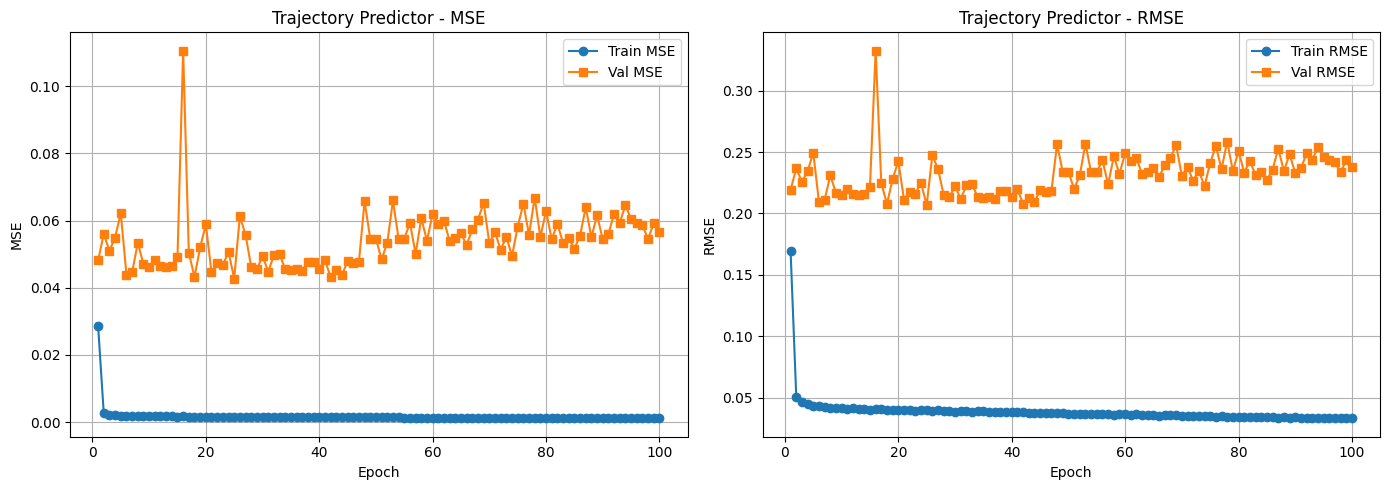


=== FINAL SUMMARY (cluster 1) ===
Best epoch       : 25
Best Val MSE     : 0.042723
Best Val RMSE    : 0.206696
Train MSE @ best : 0.001570
Train RMSE @ best: 0.039620


In [19]:
import matplotlib.pyplot as plt

total_epochs = range(1, len(train_mses) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# MSE plot
ax1.plot(total_epochs, train_mses, label="Train MSE", marker="o")
ax1.plot(total_epochs, val_mses,   label="Val MSE",   marker="s")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE")
ax1.set_title("Trajectory Predictor - MSE")
ax1.legend()
ax1.grid(True)

# RMSE plot
ax2.plot(total_epochs, train_rmses, label="Train RMSE", marker="o")
ax2.plot(total_epochs, val_rmses,   label="Val RMSE",   marker="s")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("RMSE")
ax2.set_title("Trajectory Predictor - RMSE")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\n=== FINAL SUMMARY (cluster 1) ===")
print(f"Best epoch       : {best_epoch}")
print(f"Best Val MSE     : {best_val_mse:.6f}") 
print(f"Best Val RMSE    : {val_rmses[best_epoch-1]:.6f}")
print(f"Train MSE @ best : {train_mses[best_epoch-1]:.6f}")
print(f"Train RMSE @ best: {train_rmses[best_epoch-1]:.6f}")


### Plot one past 30 minutes vs. predicted future 30 minutes / actual future 30 minutes

In [20]:
import numpy as np
import pandas as pd
import plotly.express as px

def plot_example_plotly(model, val_loader, device, example_idx=0, feature_idx=0):
    """
    Plot with Plotly:
      - past 30 minutes
      - true future 30 minutes
      - predicted future 30 minutes

    feature_idx: which feature to plot over time (0 = UTM_x, 1 = UTM_y, etc.)
    """
    model.eval()
    xb, yb = next(iter(val_loader))   # xb: (B, T_in, D), yb: (B, T_out, D)
    xb = xb.to(device)
    yb = yb.to(device)

    with torch.no_grad():
        yb_pred = model(
            xb,
            target_length=yb.size(1),
            targets=None,
            teacher_forcing_ratio=0.0,
        )

    xb_ex = xb[example_idx].detach().cpu().numpy()       # (T_in, D)
    y_true = yb[example_idx].detach().cpu().numpy()      # (T_out, D)
    y_pred = yb_pred[example_idx].detach().cpu().numpy() # (T_out, D)

    T_in = xb_ex.shape[0]
    T_out = y_true.shape[0]

    time_past   = np.arange(T_in)
    time_future = np.arange(T_in, T_in + T_out)

    past_df = pd.DataFrame({
        "time_step": time_past,
        "value": xb_ex[:, feature_idx],
        "segment": "Past (30 min)",
    })
    true_df = pd.DataFrame({
        "time_step": time_future,
        "value": y_true[:, feature_idx],
        "segment": "True future (30 min)",
    })
    pred_df = pd.DataFrame({
        "time_step": time_future,
        "value": y_pred[:, feature_idx],
        "segment": "Predicted future (30 min)",
    })

    df = pd.concat([past_df, true_df, pred_df], ignore_index=True)

    fig = px.line(
        df,
        x="time_step",
        y="value",
        color="segment",
        markers=True,
        title=f"Past + True vs Predicted future (feature {feature_idx})",
        labels={"value": "Normalized value", "time_step": "Time step"},
    )
    fig.update_layout(legend_title_text="")
    fig.show()


In [21]:
plot_example_plotly(model, val_loader, device=device, example_idx=0, feature_idx=0)
plot_example_plotly(model, val_loader, device=device, example_idx=0, feature_idx=1)

## These figures show the normalized trajectories. 
## We need to use the scalar to be able to see the actual values

Would also be cool to plot the actual vs. predicted on a map of denmark with plotly.express